# Predicting Insurance Risk with Machine Learnign Models

## Introduction

Effectively assessing customer risk profile is crucial to the success of insurance firms. High risk means customers are more likely to file a claim and therefore the company would be more likely to loose money on this customer. Tried and true quantification methods are traditionally used for this task and have been highly successful in the past. However with the rise of machine learning methods and ease of access to some of the most cutting edge models in order to sztay competitive it is necessary to test and evaluate these new methods and assess whether or not they could potentially be an improvement on previously used methods.

### The Business Goal

Minimise financial losses by understanding the risk profile of their customers to enable appropriate product pricing.

### The Task

Build a machine learning model that predicts the probability of a customer filing an insurance claim within one year, using synthetic customer data and compare it"s performance to traditional methods.

### The Hypothesis

1. Can machine learning models be used to ensure that only 5% of people who take on a policy claim on their policy.

## Solution

In [25]:
# Import Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Data Synthesis

In [26]:
#constants
num_samples = 10000
num_features_total = 40

In [27]:
# Set random seed for reproducability
np.random.seed(2)

In [28]:
# Feature generation functions
def rand_cat(options): return np.random.choice(options)
def rand_ord(options): return np.random.choice(options)
def rand_num(mean, std, low=None, high=None):
    val = np.random.normal(mean, std)
    if low is not None and val < low: val = low
    if high is not None and val > high: val = high
    return round(val, 2)

# Define base features (12 meaningful ones)
def generate_customer(idx):
    return {
        "customer_id": f"CUST{idx:05d}",
        "age": rand_num(45, 12, 18, 90),
        "income": rand_num(50000, 20000, 10000, 200000),
        "credit_score": rand_num(650, 70, 300, 850),
        "dependents": np.random.poisson(1.5),
        "gender": rand_cat(["Male", "Female", "Other"]),
        "marital_status": rand_cat(["Single", "Married", "Divorced", "Widowed"]),
        "education": rand_cat(["High School", "Bachelor", "Master", "PhD", "None"]),
        "occupation": rand_cat(["Engineer", "Teacher", "Doctor", "Lawyer", "Clerk", "Unemployed"]),
        "health_status": rand_ord(["Poor", "Fair", "Good", "Very Good", "Excellent"]),
        "driving_record": rand_ord(["Bad", "Average", "Good"]),
        "home_ownership": rand_ord(["None", "Renter", "Owner"]),
    }

# Create dataset
data = []
for i in range(num_samples):
    person = generate_customer(i)
    for j in range(num_features_total - len(person) + 1):  # +1 because customer_id is excluded
        person[f"feature_{j+1}"] = rand_num(0, 1)
    # Simulate binary target
    person["claim_status"] = np.random.choice([0, 1])
    data.append(person)

df = pd.DataFrame(data)


In [29]:
df.head()

,customer_id,age,income,credit_score,dependents,gender,marital_status,education,occupation,health_status,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,claim_status
0,CUST00000,40.00,48874.66,500.47,1,Female,Widowed,Master,Clerk,Excellent,...,-0.43,0.61,1.10,0.03,1.18,-1.12,-0.86,-0.53,1.11,1
1,CUST00001,52.34,50959.41,591.96,2,Female,Married,Bachelor,Doctor,Excellent,...,-0.32,0.05,-2.28,0.20,0.13,-0.33,1.21,-1.45,1.20,0
2,CUST00002,42.73,48455.63,707.73,0,Other,Widowed,High School,Engineer,Very Good,...,-0.13,1.17,-0.12,1.05,0.04,0.16,1.49,-0.40,0.65,0
3,CUST00003,32.74,58647.91,627.35,3,Other,Single,Bachelor,Engineer,Fair,...,0.34,1.03,-0.90,-1.26,-0.09,0.16,1.28,1.00,-0.43,0
4,CUST00004,39.38,24905.59,658.74,3,Other,Single,PhD,Unemployed,Poor,...,-1.63,-0.29,-0.31,0.49,-0.08,0.57,-0.74,1.24,-1.32,0


### Data Exploration & Preprocessing

Exploration begins with a high level inspection to understand the data structure and check for data quality issuess. This helped identify.
- Any missing values that need to be addressed
- Feature types
- Class distribution
- Categorical distribution
- Duplicates or anomolies
- Correlation (had any features been highly correlated we could discard some of the less correlated features for a better performing model.)

Even distribution across categorical features and the target variable meant there was no need for special handling to get an even sample across categories.

In [30]:
# Dataset has no missing values but this is how to check
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: int64)

In [31]:
# Look at descriptive statistics for the data
df.describe(include=[np.number])


,age,income,credit_score,dependents,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,claim_status
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,45.171567,50178.771184,649.722960,1.506300,0.008117,-0.004292,-0.009419,-0.000195,-0.008383,0.001596,...,0.027618,0.001440,-0.005786,-0.004566,-0.007576,-0.009722,0.015157,0.000179,-0.003935,0.495700
std,11.834710,19653.485929,69.358107,1.227807,0.996828,1.005207,1.001435,0.993832,1.003130,1.001522,...,0.996598,1.012907,1.008144,1.001382,0.999061,1.002047,1.002761,1.000473,0.994578,0.500007
min,18.000000,10000.000000,378.340000,0.000000,-3.730000,-3.650000,-3.630000,-3.750000,-3.850000,-3.630000,...,-3.630000,-3.440000,-4.090000,-4.070000,-4.430000,-4.040000,-3.730000,-3.540000,-4.070000,0.000000
25%,37.100000,36535.547500,603.380000,1.000000,-0.660000,-0.670000,-0.690000,-0.660000,-0.670000,-0.680000,...,-0.660000,-0.680000,-0.680000,-0.670000,-0.680000,-0.680000,-0.660000,-0.680000,-0.680000,0.000000
50%,45.210000,50024.020000,649.540000,1.000000,0.010000,-0.010000,-0.020000,-0.010000,-0.010000,-0.010000,...,0.040000,0.000000,-0.000000,0.000000,-0.010000,-0.010000,0.010000,0.000000,-0.010000,0.000000
75%,53.050000,63233.097500,696.410000,2.000000,0.690000,0.670000,0.670000,0.670000,0.660000,0.680000,...,0.700000,0.660000,0.670000,0.670000,0.670000,0.672500,0.690000,0.680000,0.660000,1.000000
max,90.000000,126629.360000,850.000000,8.000000,3.740000,3.800000,3.440000,3.930000,4.370000,3.900000,...,4.320000,3.730000,4.510000,3.770000,4.220000,3.740000,3.540000,3.500000,4.380000,1.000000


In [32]:
# Look up frequencies of categories in categorical features

categorical_cols = ['gender', 'marital_status', 'education', 'occupation',
                    'health_status', 'driving_record', 'home_ownership']

for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())



gender value counts:
gender
Other     3355
Male      3333
Female    3312
Name: count, dtype: int64

marital_status value counts:
marital_status
Single      2533
Divorced    2509
Widowed     2489
Married     2469
Name: count, dtype: int64

education value counts:
education
Bachelor       2053
High School    2027
PhD            1994
None           1972
Master         1954
Name: count, dtype: int64

occupation value counts:
occupation
Clerk         1742
Unemployed    1718
Engineer      1700
Doctor        1633
Teacher       1604
Lawyer        1603
Name: count, dtype: int64

health_status value counts:
health_status
Poor         2056
Excellent    2018
Fair         2009
Very Good    1964
Good         1953
Name: count, dtype: int64

driving_record value counts:
driving_record
Good       3369
Average    3356
Bad        3275
Name: count, dtype: int64

home_ownership value counts:
home_ownership
None      3376
Renter    3355
Owner     3269
Name: count, dtype: int64


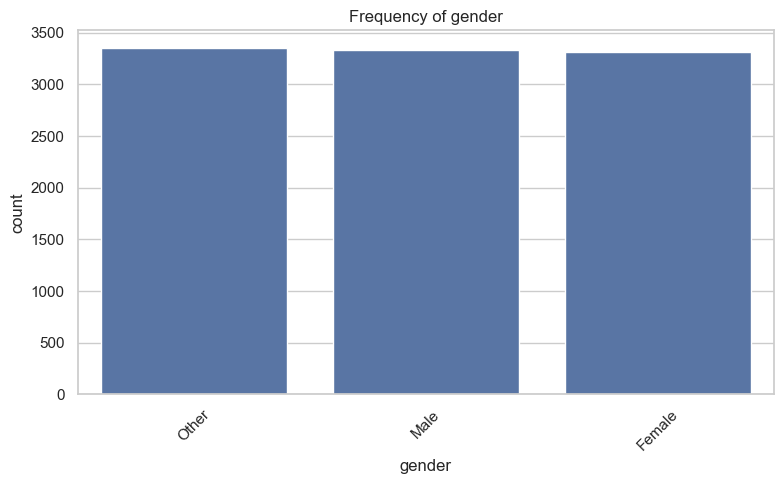

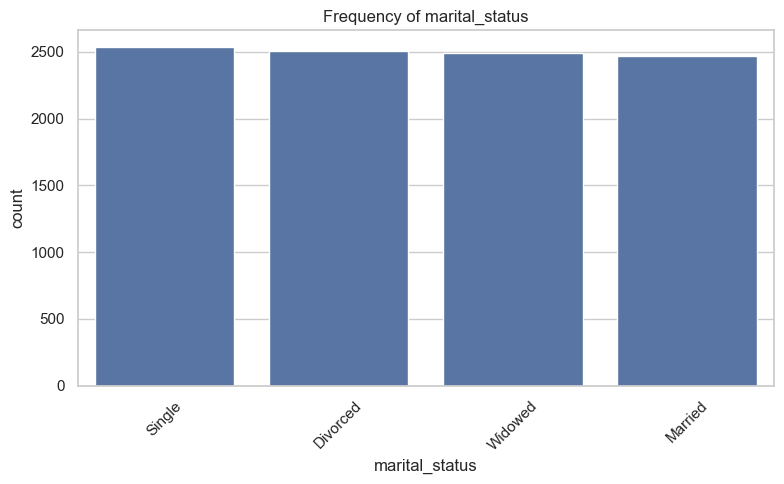

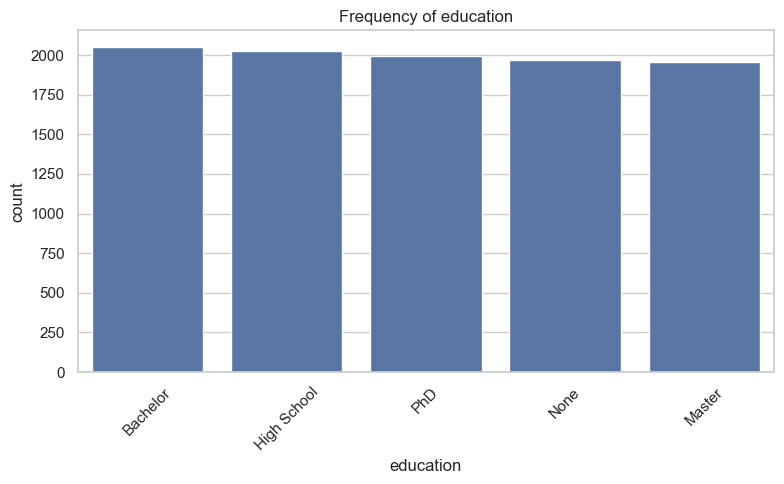

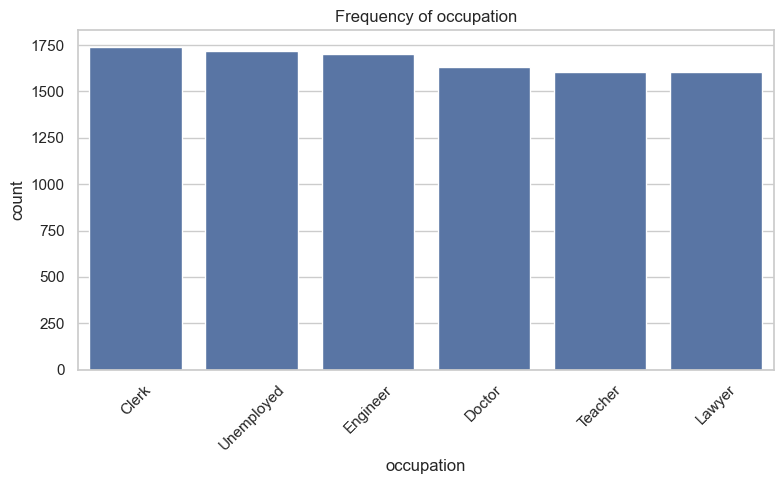

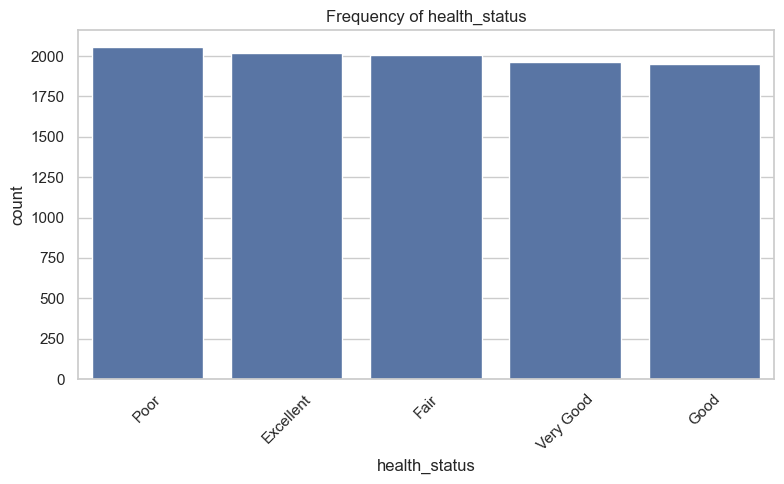

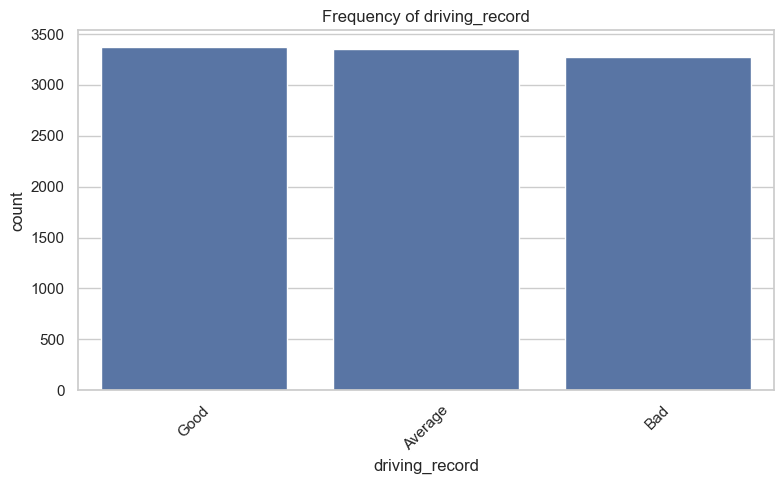

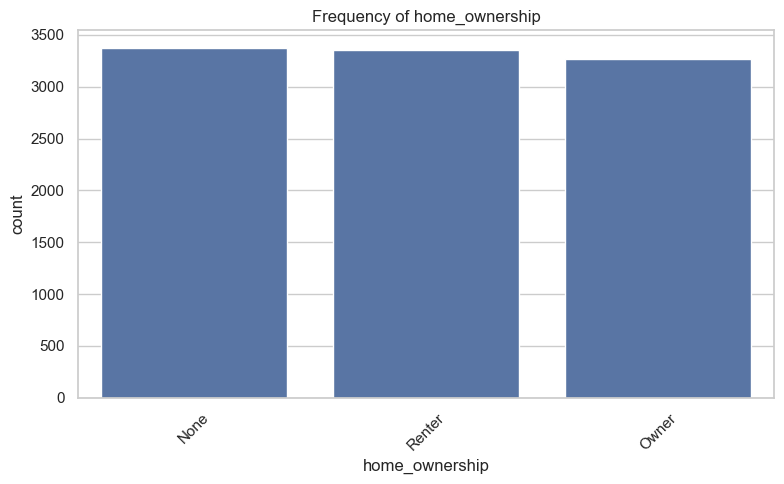

In [33]:
# Plot the frequencies
sns.set_theme(style="whitegrid")

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Frequency of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
# Check representation of target variables
df["claim_status"].value_counts(normalize=True)

claim_status
0    0.5043
1    0.4957
Name: proportion, dtype: float64

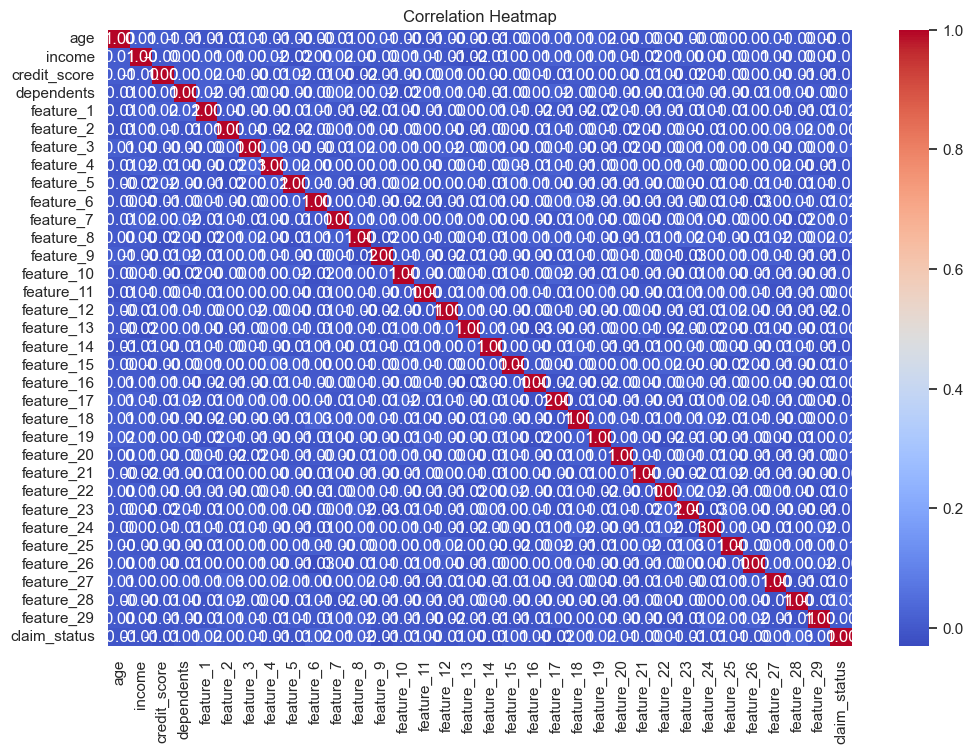

In [35]:
# Look for any correlation between numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


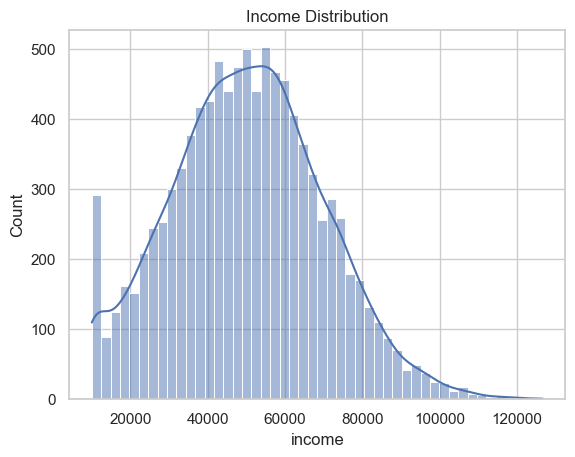

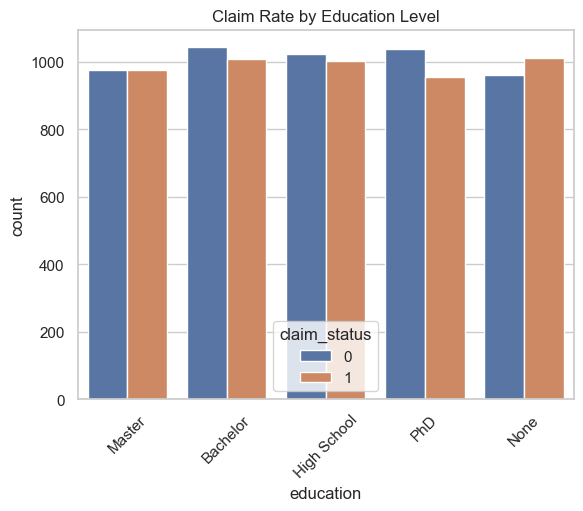

In [36]:
# Visualise key distributions
sns.histplot(df["income"], kde=True)
plt.title("Income Distribution")
plt.show()

sns.countplot(x="education", hue="claim_status", data=df)
plt.title("Claim Rate by Education Level")
plt.xticks(rotation=45)
plt.show()


In [37]:
# Dataset has no duplicated but this is how to check

duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [38]:
# Look at the number of unique counts per categorical feature 
# this is known since we generated the data but it is important to check

df.nunique().sort_values()

claim_status          2
gender                3
driving_record        3
home_ownership        3
marital_status        4
education             5
health_status         5
occupation            6
dependents            9
feature_15          559
feature_11          567
feature_28          570
feature_1           571
feature_2           572
feature_14          572
feature_3           573
feature_26          573
feature_25          576
feature_13          579
feature_7           580
feature_8           580
feature_17          581
feature_9           581
feature_29          581
feature_23          581
feature_16          582
feature_4           582
feature_21          583
feature_18          583
feature_24          584
feature_20          584
feature_5           587
feature_6           587
feature_12          588
feature_19          588
feature_10          590
feature_27          592
feature_22          600
age                4097
credit_score       8230
income             9780
customer_id     

In [39]:
df.shape

(10000, 42)

In [40]:
df_dummy = df.drop(columns=["customer_id"])

In [41]:
df_dummy.shape

(10000, 41)

One hot encoding for categorical features to simplify model training.

In [42]:
df_dummy = pd.get_dummies(df_dummy, drop_first=True)

In [43]:
df_dummy.shape

(10000, 56)

In [44]:
y = df_dummy["claim_status"]

In [45]:

X = df_dummy.drop(columns = ["claim_status"])

In [46]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

### Modelling

In [47]:
# Using RandomForestClassifier (Allows for non linear classification)

model = RandomForestClassifier(random_state=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1495
           1       0.51      0.42      0.46      1505

    accuracy                           0.51      3000
   macro avg       0.51      0.51      0.50      3000
weighted avg       0.51      0.51      0.50      3000



Model Evaluation:

1. The overall accuracy of the model is 0.51, given the data is split between our target classes 50/50 this is no better than random guessing
2. Low recall on class 1 shows that the model is missing genuine claims, disasterous for an insurance company as this would mean more claims being made within the first year of the customer's policy.
3. The model is not fit well to the data hence the poor performance.

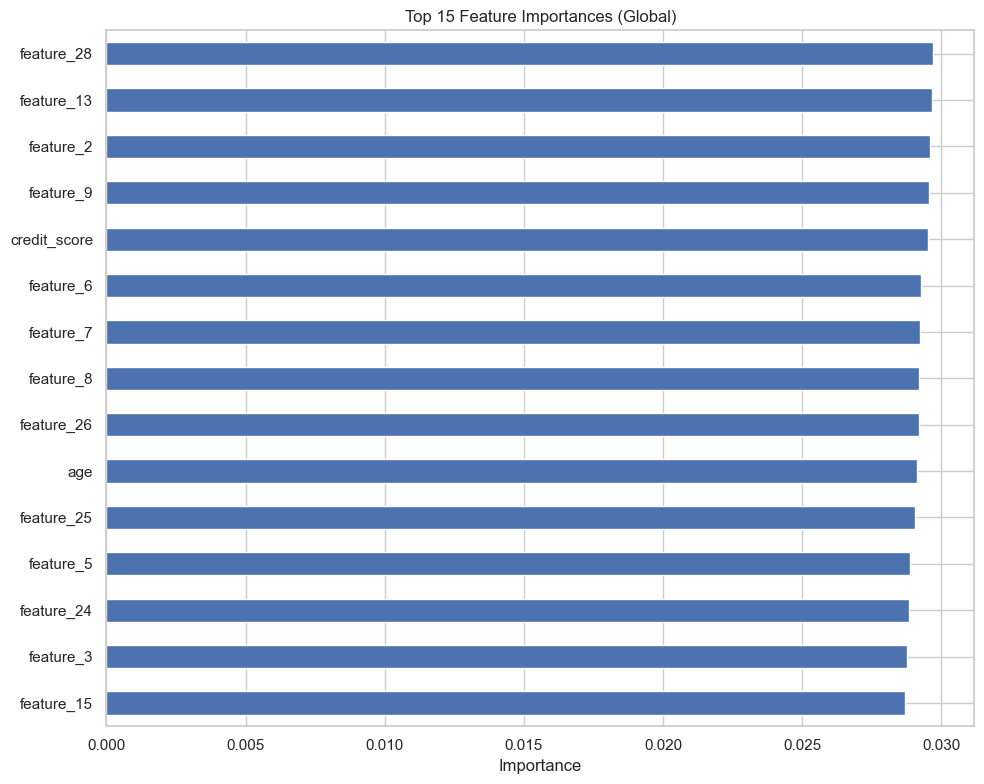

In [48]:
# Explainability

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
feat_importance.tail(15).plot(kind='barh')  # Top 15
plt.title("Top 15 Feature Importances (Global)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

1. You can see from the graph the random feature 28 has the most influence on the classification outcome. However the difference in importance between this feature and other features is minimal.

### Productionising

Develop a pipeline:
1. Export the model using a using pickle so it can be reused outside this notebook.
2. Serve the model via a REST API (flask/FastAPI) for other systems e.g. a webapp to query.
3. Add data validation checks including data quality, formatting and missing values.
4. Unit test the pipeline, test the api and validate outputs
5. Deploy to the cloud and set up monitoring.

### Considerations

1. Ensure sensitive customer data is handled according to GDPR and company policies
2. Mask or Exclude personally identifiable information if it's not essential
3. Check UK and EU guidelines on acceptable features for predictng risk and therefore pricing premiums (for example artciles suggest that gender is not an acceptable feature to be used for indicating insurance prices).
4. Security: Authentication set up in the cloud to ensure only authorised personal have access to the model.